In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ephyspy.sweeps import EphysSweepSet, EphysSweep  # Custom class for handling sweeps
from ephyspy.features import *  # available spike, sweep and sweepset level features
from ephyspy.utils import get_feature
from ephyspy.analysis import plot_sweepset_diagnostics, plot_spike_features


import jupyter_black
import time

jupyter_black.load()

In [2]:
def timeit(func, msg):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{msg}: {end-start:.4f} s")
        return result

    return wrapper

In [3]:
# load test data
test_data = np.load("tests/test_sweepset.npz", allow_pickle=True)
t_set, u_set, i_set = test_data["ts"], test_data["Uts"], test_data["Its"]
t_set *= 1e-3  # ms -> s
start, end = t_set[0, 0], t_set[0, -1]
dc_offset = -14.520833986604785

# each sweep should be a Tuple of numpy arrays (t, u, i) containing time (s),
# voltage (mV), and stimulus current (pA) arrays of shape (1, n_samples)
# dc_offset is the holding current (defaults to 0 if not supplied)

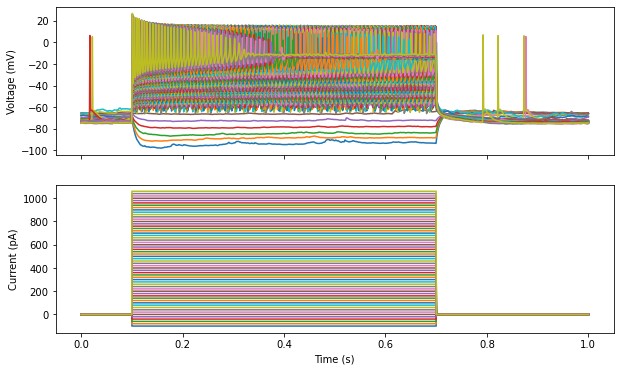

In [4]:
# what the raw data looks like
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(t_set.T, u_set.T)
axes[0].set_ylabel("Voltage (mV)")
axes[1].plot(t_set.T, i_set.T)
axes[1].set_ylabel("Current (pA)")
axes[1].set_xlabel("Time (s)")
plt.show()

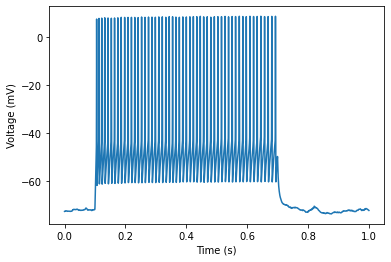

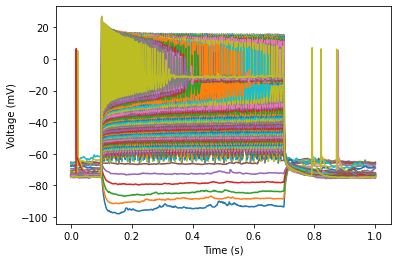

In [5]:
# The fundametal objects that this toolbox operates on a are `EphysSweep`s
# and `EphysSweepSet`s, which are wrapped versions of the AllenSDKs
# `EphysSweepExtractor` and `EphysSweepSetExtractor` classes to provide additional
# functionality and a more intuitive interface.

# These can be created from the above data as follows:
# create sweep
example_sweep = EphysSweep(
    t_set[13], u_set[13], i_set[13], filter=1, metadata={"dc_offset": dc_offset}
)

# the `.plot()` method enables quick visualization of the data
example_sweep.plot()


# create sweepset
example_sweepset = EphysSweepSet(
    t_set,
    u_set,
    i_set,
    filter=5,
    metadata={"dc_offset": dc_offset},
)

# ... which also comes with its own `.plot()` method
example_sweepset.plot()

# the metadata attribute of the sweepset can be used to supply any kind of additional
# information about sweeps or the sweepset as a whole that can be accessed later
# (e.g. for plotting or setting hyperparameters for feature calculation)

# since the sweepset is just a collection of sweeps, `EphysSweepSet` allows to access
# individual sweeps by indexing
example_sweep = example_sweepset[13]

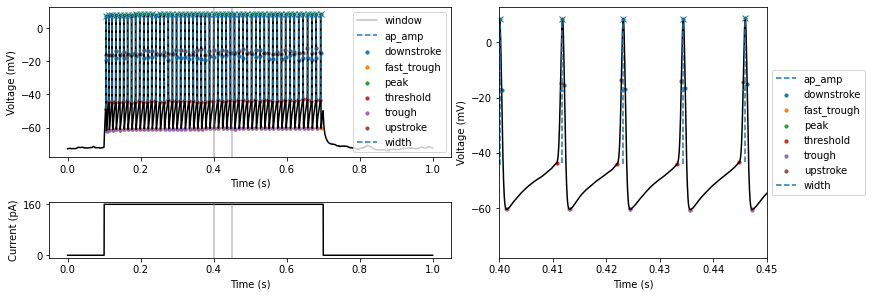

In [6]:
# These objects can already be used to calculate features on the single spike level
# (e.g. spike amplitude, spike width, etc.) by calling the `process_spikes` spikes
# method. which is mostly standard AllenSDK functionality.
example_sweep.process_spikes()

# The resulting spike features are stored in the `_spikes_df` attribute of the sweep
# and can be quickly plotted using the `plot_spike_features` from `EphysPy.plot`
plot_spike_features(example_sweep)
plt.show()

num_ap = 53.000 /.'
time to compute num_ap: 0.0165 s
time to lookup num_ap: 0.0000 s
53
{'peak_i': array([ 2636,  2830,  3054,  3303,  3572,  3844,  4108,  4380,  4656,
        4938,  5215,  5494,  5768,  6046,  6329,  6606,  6897,  7181,
        7458,  7743,  8030,  8316,  8600,  8874,  9147,  9429,  9716,
       10003, 10296, 10580, 10860, 11149, 11427, 11720, 12012, 12303,
       12597, 12892, 13182, 13471, 13764, 14047, 14354, 14644, 14928,
       15229, 15526, 15822, 16125, 16430, 16723, 17024, 17324]), 'peak_t': array([0.10544, 0.1132 , 0.12216, 0.13212, 0.14288, 0.15376, 0.16432,
       0.1752 , 0.18624, 0.19752, 0.2086 , 0.21976, 0.23072, 0.24184,
       0.25316, 0.26424, 0.27588, 0.28724, 0.29832, 0.30972, 0.3212 ,
       0.33264, 0.344  , 0.35496, 0.36588, 0.37716, 0.38864, 0.40012,
       0.41184, 0.4232 , 0.4344 , 0.44596, 0.45708, 0.4688 , 0.48048,
       0.49212, 0.50388, 0.51568, 0.52728, 0.53884, 0.55056, 0.56188,
       0.57416, 0.58576, 0.59712, 0.60916, 0.62104, 0.63

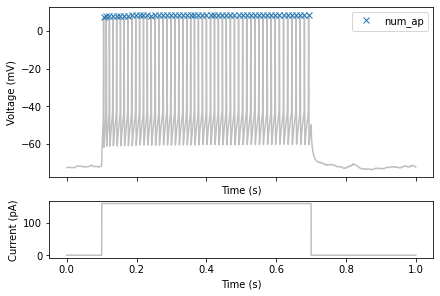

In [7]:
# Every feature that can be computed in `EphysPy` (apart from spike level features for now)
# is defined as a self-contained class, which inherit from `SweepFeature` and `SweepSetFeature`.
# and they can be found in the `ephyspy.features.base` module.

# This allows to handle features very flexibly and intuitively, by simply
# instantiating a feature object, e.g.:
num_ap = Sweep_Num_AP(example_sweep)
print(num_ap)
# if not otherwise specified the feature is computed automatically at initialization
# however, this can be disabled as well if you just want to instantiate it for later use.
# If the feature has already been computed, it will not be recomputed unless explicitly
# requested and the cached value will be returned instead. This speeds up computation
# if the feature is reused during computation of other features.

timeit(lambda: num_ap.get_value(recompute=True), "time to compute num_ap")()
timeit(num_ap.get_value, "time to lookup num_ap")()

# Every feature is defined via its `_compute` method, that returns a feature's value
# and which can make use of everyhting that is available in the sweep object, i.e.
# the time, voltage and current arrays, as well as the metadata or even other features.
# This allows to easily define new features or modify existing ones, just by changing
# the `_compute` method. Furthermore, other features can be looked up during computation
# in a recursive manner, i.e. if a feature depends on another feature, the latter will
# be computed automatically if it is not already available. This enables every feature
# to be computed on its own and at any time, without having to worry about the order
# of computation.

# A feature's value can be accessed via its `value` attribute
print(num_ap.value)

# along with its value intermediate results of a feature's computation can also be
# stored and accsed via the `diagnostics` attribute.
print(num_ap.diagnostics)

# This helps with debugging and understanding how a feature is computed.
# This is further facilitated by the `plot` method, which can added to every
# feature and be used to visualize a feature's value and diagnostics.
num_ap.plot(show_sweep=True, show_stimulus=True)
plt.show()

# For additional information see the package's documentation

In [8]:
# This package already comes with a large number of features that can be used
# out of the box. These can be found in the `ephyspy.features` module.

# and can be listed as follows:

print("Available spike features:", list(available_spike_features().keys()))
print("Available sweep features:", list(available_sweep_features().keys()))
print("Available sweepset features:", list(available_sweepset_features().keys()))

# and computed via `get_feature`:
print("Num_AP:", get_feature("num_ap", example_sweep))

Available spike features: ['ap_adp', 'ap_ahp', 'ap_udr', 'ap_amp', 'ap_downstroke', 'ap_fast_trough', 'ap_peak', 'ap_slow_trough', 'ap_thresh', 'ap_trough', 'ap_upstroke', 'ap_width', 'isi']
Available sweep features: ['ap_adp', 'ap_ahp', 'ap_cv', 'ap_ff', 'ap_udr', 'ap_amp', 'ap_amp_adapt', 'ap_amp_adapt_avg', 'ap_amp_slope', 'ap_freq', 'ap_freq_adapt', 'ap_latency', 'ap_peak', 'ap_thresh', 'ap_trough', 'ap_width', 'burstiness', 'isi', 'isi_cv', 'isi_ff', 'isi_adapt', 'isi_adapt_avg', 'num_ap', 'num_bursts', 'r_input', 'rebound', 'rebound_aps', 'rebound_area', 'rebound_avg', 'rebound_latency', 'sag', 'sag_area', 'sag_fraction', 'sag_ratio', 'sag_time', 'stim_amp', 'stim_end', 'stim_onset', 'tau', 'v_baseline', 'v_deflect', 'v_plateau', 'v_rest', 'v_sag', 'v_steady', 'wildness']
Available sweepset features: ['ap_adp', 'ap_ahp', 'ap_cv', 'ap_ff', 'ap_udr', 'ap_amp', 'ap_amp_adapt', 'ap_amp_adapt_avg', 'ap_amp_slope', 'ap_freq', 'ap_freq_adapt', 'ap_latency', 'ap_peak', 'ap_thresh', 'ap_t

In [9]:
# A different and perhaps more convenient way to interface with features is via
# the `add_features` method of `EphysSweep` and `EphysSweepSet`, which allows to
# add multiple features at once, either by name or by passing a list of feature objects.

# features can be added via the `add_features` method
example_sweep.add_features(available_spike_features())
example_sweep.add_features(available_sweep_features())

# and are stored in the `features` attribute
print("Spike features:", example_sweep.features)

# so far the features we just added, but have not been computed yet, we can do this
# either individually or all at once

# any single feature can be accessed by just calling its value
# if the feature has not been computed yet, it will be computed
print("Number of spikes:", example_sweep.features["num_ap"].value)

# computing all features at once can be done via the `get_features` method
example_sweep.get_features()

Spike features: {'num_ap': num_ap for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'stim_onset': stim_onset for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'stim_end': stim_end for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_adp': ap_adp for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_ahp': ap_ahp for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_cv': ap_cv for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_ff': ap_ff for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_udr': ap_udr for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_amp': ap_amp for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_amp_adapt': ap_amp_adapt for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_amp_adapt_avg': ap_amp_adapt_avg for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_amp_slope': ap_amp_slope for <ephyspy.sweeps.EphysSweep object at 0x7f858a222e80>, 'ap_freq': ap_freq for <ephyspy

{'num_ap': 53,
 'stim_onset': 0.10003999999999998,
 'stim_end': 0.7,
 'ap_adp': nan,
 'ap_ahp': -16.687004841164267,
 'ap_cv': 0.011883420429187254,
 'ap_ff': 0.007402170389396776,
 'ap_udr': 0.8329492365104244,
 'ap_amp': 52.37854949340192,
 'ap_amp_adapt': 0.9370053926841857,
 'ap_amp_adapt_avg': 0.9987194594588579,
 'ap_amp_slope': 1.2669896049484088,
 'ap_freq': 88.33922261484099,
 'ap_freq_adapt': 0.9629629629629629,
 'ap_latency': 0.004240000000000008,
 'ap_peak': 8.5308712381146,
 'ap_thresh': -43.900987193047115,
 'ap_trough': -60.57095916316339,
 'ap_width': 0.0010000000000000009,
 'burstiness': nan,
 'isi': 0.011360000000000037,
 'isi_cv': 0.06489159787251618,
 'isi_ff': 4.758339006126631e-05,
 'isi_adapt': 1.1538461538461546,
 'isi_adapt_avg': 1.0092691310705475,
 'num_bursts': nan,
 'r_input': nan,
 'rebound': nan,
 'rebound_aps': nan,
 'rebound_area': nan,
 'rebound_avg': nan,
 'rebound_latency': nan,
 'sag': nan,
 'sag_area': nan,
 'sag_fraction': nan,
 'sag_ratio': nan,


In [10]:
# This workflow does also apply to sweepsets as it does to sweeps.
# again features can be added via the `add_features` method
example_sweepset.add_features(available_spike_features())
example_sweepset.add_features(available_sweepset_features())

# and are stored in the `features` attribute
print("Spike features:", example_sweepset.features)

# again any single feature can be accessed by just calling its value
print("Number of spikes:", example_sweepset.features["num_ap"].value)

# computing all features at once can be done via the `get_features` method
example_sweepset.get_features()

Spike features: {'ap_adp': ap_adp for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_ahp': ap_ahp for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_cv': ap_cv for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_ff': ap_ff for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_udr': ap_udr for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_amp': ap_amp for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_amp_adapt': ap_amp_adapt for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_amp_adapt_avg': ap_amp_adapt_avg for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_amp_slope': ap_amp_slope for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_freq': ap_freq for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_freq_adapt': ap_freq_adapt for <ephyspy.sweeps.EphysSweepSet object at 0x7f858ba6b520>, 'ap_latency': ap_latency for <ephyspy.sweeps.EphysSweepSet object at 

{'ap_adp': 1.0387881823916842,
 'ap_ahp': -13.755693457105863,
 'ap_cv': 0.11469494259026809,
 'ap_ff': 0.6592463822915464,
 'ap_udr': 0.8728326017752597,
 'ap_amp': 49.297157904837,
 'ap_amp_adapt': 0.9693982830348038,
 'ap_amp_adapt_avg': 0.9991958090212181,
 'ap_amp_slope': -0.34544282397117093,
 'ap_freq': 151.6767784518968,
 'ap_freq_adapt': 0.8958333333333334,
 'ap_latency': 0.02316,
 'ap_peak': 14.417336167559261,
 'ap_thresh': -34.86354152985883,
 'ap_trough': -48.64061814949339,
 'ap_width': 0.001040000000000041,
 'burstiness': nan,
 'isi': 0.006720000000000059,
 'isi_cv': 0.10236501042148181,
 'isi_ff': 6.956390172056001e-05,
 'isi_adapt': 1.1456692913385835,
 'isi_adapt_avg': 1.010434883394085,
 'num_ap': 91.0,
 'num_bursts': nan,
 'r_input': 257.0917765262029,
 'rebound': 4.217762775171707,
 'rebound_aps': nan,
 'rebound_area': 0.6927822162866062,
 'rebound_avg': 2.4772894251494932,
 'rebound_latency': 0.020320000000000005,
 'rheobase': 39.28273874850954,
 'sag': -30.750646

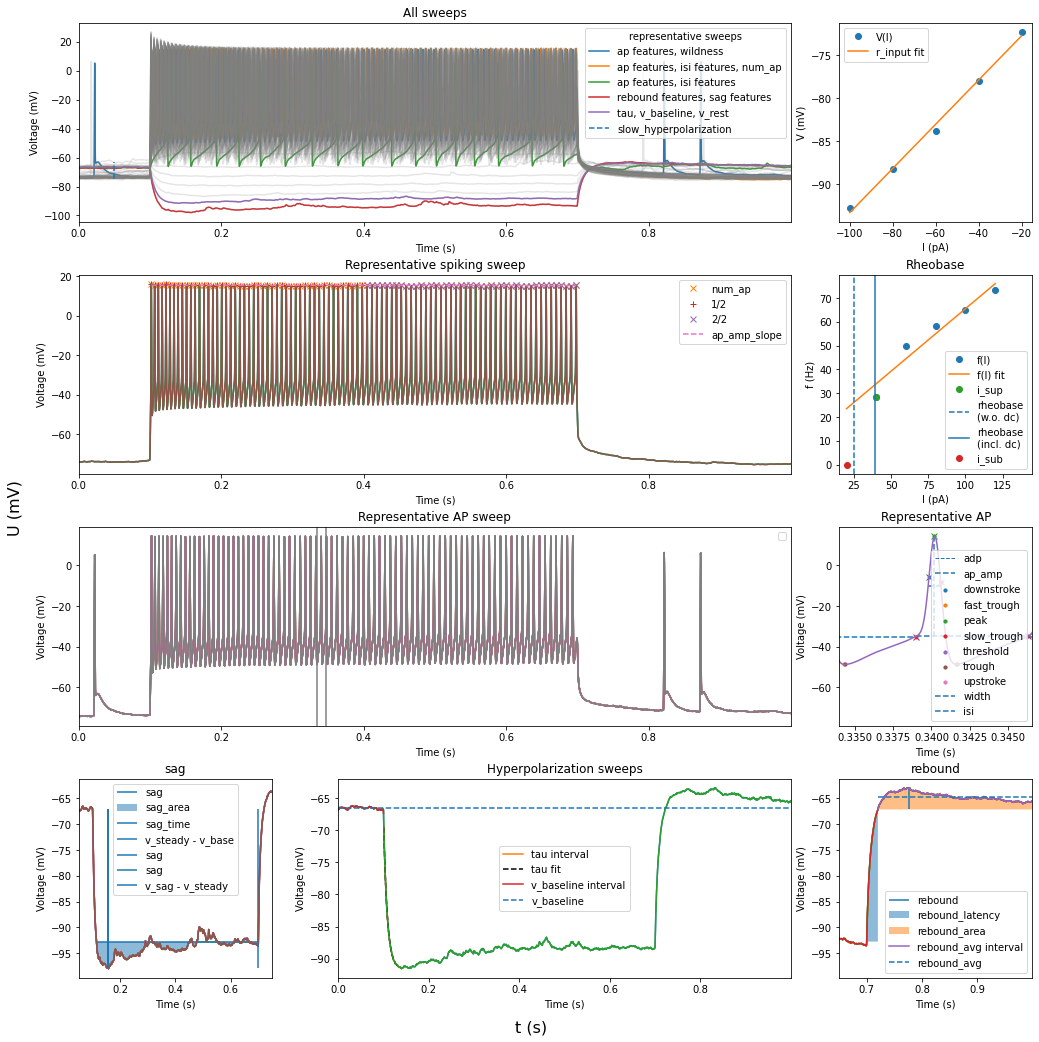

In [11]:
# Along with the abilty to compute and plot every feature on the individual level
# `EphysPy` also provides several higher level plotting functions that can be used
# to derive insights from the data.

# For example, `plot_sweepset_diagnostics` can be used to better trace how features
# were computed across a sweepset.

plot_sweepset_diagnostics(example_sweepset)
plt.show()

In [12]:
# To add custom features to the `EphysPy` ecosystem, they can be registered via
# the `register_custom_feature` function, which takes a feature class as input
# and stores it in a dictionary in the `ephyspy.features` module. This allows
# to access the feature via its name and to use it in the same way as any other
# feature, i.e. make use of recursive computation, caching, etc.

# Features should inherit from `SweepFeature` and/or `EphysSweepFeature` (in the case
# of spike features they can just be a function that expects a `EphysSweep` object).

# For more info see the package's documentation
print(register_custom_feature.__doc__, "\n")
print(SweepFeature.__doc__)

Add a custom feature class that inherits from `SweepFeature`
    or from `SweepSetFeature`. This makes the feature available to all the
    the EphysPy functionalities such as recursive computation of all dependend
    features that are called with `lookup_X_feature`, where X can be spike,
    sweep or sweepset.

    Args:
        Feature: Feature class to be added to EphysPy ecosystem. Feature
            must inherit from either `SweepFeature` or `SweesetFeature`.
     

Base class for all sweep level electrophysiological features.

    This class defines the interface for all electrophysiological features.
    All features should inherit from this class, and must implement the
    `_compute` method. The `_compute` method should return the feature value
    and optionally save diagnostic information for later debugging to
    `self._diagnostics`.

    The description of the feature should contain a short description of the
    feature, and a list of dependencies. The dependencies sho